# Run MMBT Experiments

This notebook shows the end-to-end pipeline for fine-tuning pre-trained MMBT model for multimodal (text and image) classification on our dataset.

Parts of this pipeline are adapted from the
Huggingface `run_mmimdb.py` script to execute the MMBT model. This code can
be accessed [here.](https://github.com/huggingface/transformers/blob/8ea412a86faa8e9edeeb6b5c46b08def06aa03ea/examples/research_projects/mm-imdb/run_mmimdb.py#L305)

## 🔐 Hugging Face Authentication (Required)

**Important**: The dataset requires Hugging Face authentication. Please login before loading the dataset.

### Method 1: Using Hugging Face CLI (Recommended)

Run the following commands in a terminal before starting Jupyter:

```bash
# Install huggingface_hub (if not already installed)
pip install huggingface_hub

# Login to Hugging Face
huggingface-cli login
```

When prompted, enter your Hugging Face token. You can get your token from:
- https://huggingface.co/settings/tokens

### Method 2: Set Token in Notebook

If you cannot use CLI login (e.g., on web platforms), run the cell below to set your token directly.

### Method 3: Pass Token Directly in Code

If the above methods don't work, you can pass the token directly in the `load_examples` function. Find the `load_examples` function (usually in Cell 8) and modify the `load_dataset` call:

**Original code:**
```python
hf_dataset_dict = load_dataset("Vinjou/Multimodal_urban_livability_evaluation_dataset")
```

**Modified code (with token):**
```python
hf_dataset_dict = load_dataset("Vinjou/Multimodal_urban_livability_evaluation_dataset", token="your_token_here")
```

Replace `"your_token_here"` with your actual Hugging Face token.

In [1]:
import os
os.environ['HF_TOKEN'] = 'your_token_here'  # Replace with your actual token


In [2]:
# Install huggingface_hub if not already installed
import subprocess
import sys

try:
    import huggingface_hub
    print("✓ huggingface_hub is already installed")
except ImportError:
    print("Installing huggingface_hub...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "huggingface_hub"])
    print("✓ huggingface_hub installed successfully")

# Check if already logged in
from huggingface_hub import HfFolder
token = HfFolder.get_token()

if token:
    print("✓ Hugging Face token found. You are already logged in.")
    print(f"  Token starts with: {token[:10]}...")
else:
    print("⚠️  No Hugging Face token found.")
    print("Please login using one of the following methods:")
    print("  1. Run in terminal: huggingface-cli login")
    print("  2. Or set token below:")
    print()
    print("# Uncomment and set your token:")
    print("# import os")
    print("# os.environ['HF_TOKEN'] = 'your_token_here'")

✓ huggingface_hub is already installed


/u/wz53/miniconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Hugging Face token found. You are already logged in.
  Token starts with: hf_ycsMJxd...


In [3]:
# textBert_utils.py is imported as a module in later cells, not run directly
# The file exists in the same directory as this notebook
print("textBert_utils.py is available and will be imported as needed")

textBert_utils.py is available and will be imported as needed


In [4]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: NVIDIA H100 80GB HBM3


## Install Huggingface Library

These should have been installed during your environment set-up; you only need to run these cells in Google Colab.

## Import Required Modules

In [5]:
import sys
import os

# Add the project directory to sys.path to allow importing local modules
# Find the directory containing textBert_utils.py (notebook's directory)
current_dir = os.getcwd()
project_dir = None

# Search for textBert_utils.py in multiple possible locations
search_dirs = [
    current_dir,  # Current working directory
    os.path.join(current_dir, 'Livability_evaluation_baseline'),  # Subdirectory of current
    os.path.join(os.path.dirname(current_dir), 'Livability_evaluation_baseline'),  # Parent's subdirectory
]

# Also search parent directory and its subdirectories
parent_dir = os.path.dirname(current_dir)
if parent_dir != current_dir:
    search_dirs.extend([
        parent_dir,
        os.path.join(parent_dir, 'Livability_evaluation_baseline'),
    ])

# Search all possible directories
for dir_path in search_dirs:
    dir_path = os.path.abspath(dir_path)
    test_file = os.path.join(dir_path, 'textBert_utils.py')
    if os.path.exists(test_file):
        project_dir = dir_path
        print(f'Found textBert_utils.py in: {project_dir}')
        break

# If still not found, try to search recursively in parent directories
if project_dir is None:
    search_path = current_dir
    for _ in range(3):  # Search up to 3 levels up
        test_file = os.path.join(search_path, 'textBert_utils.py')
        if os.path.exists(test_file):
            project_dir = search_path
            print(f'Found textBert_utils.py in: {project_dir}')
            break
        # Also check Livability_evaluation_baseline subdirectory
        subdir = os.path.join(search_path, 'Livability_evaluation_baseline')
        if os.path.exists(os.path.join(subdir, 'textBert_utils.py')):
            project_dir = subdir
            print(f'Found textBert_utils.py in: {project_dir}')
            break
        search_path = os.path.dirname(search_path)
        if search_path == os.path.dirname(search_path):  # Reached root
            break

# If still not found, use current directory
if project_dir is None:
    project_dir = current_dir
    print(f'Warning: textBert_utils.py not found, using current directory: {project_dir}')

# Add to sys.path if not already there
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)
    print(f'Added {project_dir} to sys.path')

# Verify the file exists
if os.path.exists(os.path.join(project_dir, 'textBert_utils.py')):
    print(f'✓ textBert_utils.py found in project directory')
else:
    print(f'✗ textBert_utils.py NOT found in project directory: {project_dir}')


Found textBert_utils.py in: /u/wz53/Livability_evaluation_baseline
Added /u/wz53/Livability_evaluation_baseline to sys.path
✓ textBert_utils.py found in project directory


In [6]:
from textBert_utils import set_seed
from MMBT_liva.image_liva import ImageEncoderDenseNet
from MMBT_liva.mmbt_config_liva import MMBTConfig
from MMBT_liva.mmbt_liva import MMBTForClassification


/u/wz53/miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/u/wz53/miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2026-01-20 03:37:52.490635: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-20 03:37:53.596605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when on

In [7]:
from MMBT_liva.mmbt_utils_liva_0318 import JsonlDataset, get_image_transforms, get_labels, load_examples, collate_fn, get_multiclass_labels, get_multiclass_criterion 

In [8]:
from datasets import load_dataset
import os
from torch.utils.data import Dataset
import torch
from MMBT_liva.mmbt_utils_liva_0318 import get_image_transforms, get_image_transforms_gray, get_image_transforms_giu

class HFDatasetWrapper(Dataset):
    def __init__(self, hf_dataset, tokenizer, transforms, transforms_gray, transforms_giu, max_seq_length):
        self.dataset = hf_dataset
        self.tokenizer = tokenizer
        self.n_classes = 6
        self.max_seq_length = max_seq_length
        self.transforms = transforms
        self.transforms_gray = transforms_gray
        self.transforms_giu = transforms_giu

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        item = self.dataset[index]
        
        # Text encoding
        sentence = torch.LongTensor(self.tokenizer.encode(item["text"], add_special_tokens=True))
        start_token, sentence, end_token = sentence[0], sentence[1:-1], sentence[-1]
        sentence = sentence[:self.max_seq_length]

        # Labels
        label = torch.zeros(self.n_classes)
        label[0] = float(item["lbm"])
        label[1] = float(item["fys"])
        label[2] = float(item["onv"])
        label[3] = float(item["soc"])
        label[4] = float(item["vrz"])
        label[5] = float(item["won"])

        # Images from HF are already PIL images
        rs = item["rs_image"].convert("RGB")
        rs = self.transforms(rs)

        dsm = item["dsm_image"].convert("RGB")
        dsm = self.transforms_gray(dsm)
        
        giu = item["giu_image"].convert("RGB")
        giu = self.transforms_giu(giu)

        # Concatenate 3 images along channel dimension (3+3+3 = 9 channels)
        image_3 = torch.cat((rs, dsm, giu), dim=0)
        
        return {
            "image_start_token": start_token,
            "image_end_token": end_token,
            "sentence": sentence,
            "image": image_3,
            "label": label,
        }

def load_examples(tokenizer, wandb_config, evaluate=False, test=False, **kwargs):
    """Overriding load_examples to use Hugging Face dataset"""
    print(f"Loading dataset 'Vinjou/Multimodal_urban_livability_evaluation_dataset' from Hugging Face... (evaluate={evaluate}, test={test})")
    # Try to load dataset with token if available
    try:
        # First, try with token from environment or Hugging Face cache
        import os
        from huggingface_hub import HfFolder
        token = os.environ.get("HF_TOKEN") or HfFolder.get_token()
        
        if not token:
            raise RuntimeError("HF token missing. Please set HF_TOKEN environment variable or run huggingface-cli login.")
        
        # Load dataset with token
        hf_dataset_dict = load_dataset("Vinjou/Multimodal_urban_livability_evaluation_dataset", token=token)
    except Exception as e:
        # If loading fails, provide helpful error message
        error_msg = str(e)
        if "Unauthorized" in error_msg or "token" in error_msg.lower():
            print("❌ Authentication required to access the dataset.")
            print("Please login to Hugging Face using one of the following methods:")
            print("  1. Run: huggingface-cli login")
            print("  2. Or set environment variable: export HF_TOKEN=your_token")
            print("  3. Or pass token directly: load_dataset(..., token=your_token)")
        raise
    
    if evaluate and not test:
        hf_dataset = hf_dataset_dict["validation"]
    elif evaluate and test:
        hf_dataset = hf_dataset_dict["test"]
    else:
        hf_dataset = hf_dataset_dict["train"]

    img_transforms = get_image_transforms()
    img_transforms_gray = get_image_transforms_gray()
    img_transforms_giu = get_image_transforms_giu()

    dataset = HFDatasetWrapper(
        hf_dataset, 
        tokenizer, 
        img_transforms, 
        img_transforms_gray, 
        img_transforms_giu, 
        wandb_config.max_seq_length - wandb_config.num_image_embeds - 2
    )
    return dataset

def hf_collate_fn(batch):
    """
    Specify batching for the Hugging Face dataset
    """
    lens = [len(row["sentence"]) for row in batch]
    bsz, max_seq_len = len(batch), max(lens)

    mask_tensor = torch.zeros(bsz, max_seq_len, dtype=torch.long)
    text_tensor = torch.zeros(bsz, max_seq_len, dtype=torch.long)

    for i_batch, (input_row, length) in enumerate(zip(batch, lens)):
        text_tensor[i_batch, :length] = input_row["sentence"]
        mask_tensor[i_batch, :length] = 1

    img_tensor = torch.stack([row["image"] for row in batch])
    tgt_tensor = torch.stack([row["label"] for row in batch])
    img_start_token = torch.stack([row["image_start_token"] for row in batch])
    img_end_token = torch.stack([row["image_end_token"] for row in batch])

    return {
        "sentence": text_tensor,
        "attention_mask": mask_tensor,
        "image": img_tensor,
        "image_start_token": img_start_token,
        "image_end_token": img_end_token,
        "label": tgt_tensor
    }


In [9]:
import argparse

In [10]:
import glob
import logging
import random
import json
import os
from collections import Counter
import numpy as np
from matplotlib.pyplot import imshow

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [11]:
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, multilabel_confusion_matrix, hamming_loss, classification_report
from tqdm import tqdm, trange

from transformers import (
    WEIGHTS_NAME,
    AutoConfig,
    AutoModel,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
)

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

# Set-up Experiment Hyperparameters and Arguments

Specify the training, validation, and test files to run the experiment on. The default here is running the model on 'impression' texts.  

To re-make the training, validation, and test data, please refer to the information in the **data/** directory.  

Change the default values in the parser.add_argument function for the hyperparameters that you want to specify in the following cell or use the default option.  

For multiple experiment runs, please make sure to change the `output_dir` argument so that new results don't overwrit existing ones.

The arguments specified here are the same as in the `run_mmimdb.py` file 
in the [Huggingface example implementation of MMBT.](https://github.com/huggingface/transformers/blob/8ea412a86faa8e9edeeb6b5c46b08def06aa03ea/examples/research_projects/mm-imdb/run_mmimdb.py#L305)

In [12]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Or ignore specific types of warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [13]:
parser = argparse.ArgumentParser(f'Project Hyperparameters and Other Configurations Argument Parser')

parser = argparse.ArgumentParser()

# Required parameters
parser.add_argument(
    "--model_name",
    default="bert-base-multilingual-uncased", 
    type=str,
    help="model identifier from huggingface.co/models",
)
#Change this if the input is Chinese,bert-base-uncased(trained on lowercase English text.) 2 bert-base-chinese(trained on simplified and traditional Chinese text with 12 hidden layers and 110M parameters.) 
parser.add_argument(
    "--output_dir",
    default="livability_4M_6aspects", #   mmbt_output_findings_10epochs_n
    type=str,
    help="The output directory where the model predictions and checkpoints will be written.",
)

    
parser.add_argument(
    "--config_name", default="bert-base-multilingual-uncased", type=str, help="Pretrained config name if not the same as model_name"
)
parser.add_argument(
    "--tokenizer_name",
    default="bert-base-multilingual-uncased",
    type=str,
    help="Pretrained tokenizer name or path if not the same as model_name",
)

parser.add_argument("--train_batch_size", default=16, type=int, help="Batch size for training.") #Changed from 32 to 16 -20;If set to 14, move last 4 eval samples to train.
parser.add_argument(
    "--eval_batch_size", default=16, type=int, help="Batch size for evaluation." #Changed from 32 to 16  -20 #Set to 1 for attention visualization
)
parser.add_argument(
    "--max_seq_length",
    default=400,#50,  #Originally 300, max 512
    type=int,
    help="The maximum total input sequence length after tokenization. Sequences longer "
    "than this will be truncated, sequences shorter will be padded.",
)
parser.add_argument(
    "--num_image_embeds", default=9, type=int, help="Number of Image Embeddings from the Image Encoder" # 3chanel *3 images
) # B*N*1024 (batch * num_image_embeds * 1024)
parser.add_argument("--do_train", default=False, type=bool, help="Whether to run training.") # Modified for testing only
parser.add_argument("--do_eval", default=True, type=bool, help="Whether to run eval on the dev set.")
parser.add_argument(
    "--evaluate_during_training", default=True, type=bool, help="Run evaluation during training at each logging step."
)


parser.add_argument(
    "--gradient_accumulation_steps",
    type=int,
    default=1,
    help="Number of updates steps to accumulate before performing a backward/update pass.",
)
parser.add_argument("--learning_rate", default=5e-05, type=float, help="The initial learning rate for Adam.") # originally default=5e-5 (0.00005);
parser.add_argument("--weight_decay", default=0.1, type=float, help="Weight deay if we apply some.")
parser.add_argument("--adam_epsilon", default=1e-8, type=float, help="Epsilon for Adam optimizer.")
parser.add_argument("--max_grad_norm", default=1.0, type=float, help="Max gradient norm.")
parser.add_argument(
    "--num_train_epochs", default=1, type=float, help="Total number of training epochs to perform."# HuggingFace default is 3, previous experiment used 10.
)
parser.add_argument("--patience", default=5, type=int, help="Patience for Early Stopping.")
parser.add_argument(
    "--max_steps",
    default=-1,
    type=int,
    help="If > 0: set total number of training steps to perform. Override num_train_epochs.",
)
parser.add_argument("--warmup_steps", default=0, type=int, help="Linear warmup over warmup_steps.") #When warmup_steps is 0, there is no warmup,only linear decay to 0

parser.add_argument("--logging_steps", type=int, default=50, help="Log every X updates steps.") #Originally 25,
parser.add_argument("--save_steps", type=int, default=50, help="Save checkpoint every X updates steps.") #Originally 25,
parser.add_argument(
    "--eval_all_checkpoints",
    default=True, type=bool,
    help="Evaluate all checkpoints starting with the same prefix as model_name ending and ending with step number",
)

parser.add_argument("--num_workers", type=int, default=8, help="number of worker threads for dataloading")

parser.add_argument("--seed", type=int, default=42, help="random seed for initialization")


args = parser.parse_args("")

# Setup CUDA, GPU & distributed training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.n_gpu = torch.cuda.device_count() if torch.cuda.is_available() else 0
args.device = device

# for multiclass labeling
args.multiclass = True #Modification 1:args.multiclass = False

## Showing a sample from JsonDataset
i.e. calling "\_\_getitem\_\_"

Note:   
image_end_token is the BERT token id for [SEP].   
image_start_token is the BERT token id for [CLS]. 


In [14]:
tokenizer = AutoTokenizer.from_pretrained(
        args.tokenizer_name if args.tokenizer_name else args.model_name,
        do_lower_case=True,
        cache_dir=None,
    )
train_dataset = load_examples(tokenizer, args)

Loading dataset 'Vinjou/Multimodal_urban_livability_evaluation_dataset' from Hugging Face... (evaluate=False, test=False)


In [15]:
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# Assume tgts and preds are already defined and calculated
# tgts and preds are multi-dimensional tensors, where each column corresponds to a different label


def plot_density_scatter(tgts, preds, label, ax, xlim, ylim):
    """
    Plot density scatter plot and set axis range
    """
    # Calculate density
    xy = np.vstack([tgts, preds])
    z = gaussian_kde(xy)(xy)
    
    # Plot scatter plot
    scatter = ax.scatter(tgts, preds, c=z, s=5, edgecolor=None, cmap='viridis')
    
    # Add color bar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Density')
    
    ax.set_xlabel(f'Ground Truth of {label}')
    ax.set_ylabel(f'Predicted value of {label}')
    ax.set_title(f'Density Scatter Plot of {label}')
    ax.grid(True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal', adjustable='box')


### Training and Evaluating Functions.

In [16]:
def train(args, train_dataset, model, tokenizer):
    """ Train the model """
    
    # add the specified batch size and output dir for current run to Tensorboard 
    # saved run's name for easy identification
    comment = f"train_{args.output_dir}_{args.train_batch_size}"
    try:
        from torch.utils.tensorboard import SummaryWriter
    except ImportError:
        from tensorboardX import SummaryWriter
    tb_writer = SummaryWriter(comment=comment)

    train_sampler = RandomSampler(train_dataset)

    train_dataloader = DataLoader(
        train_dataset,
        sampler=train_sampler,
        batch_size=args.train_batch_size,
        collate_fn=hf_collate_fn
    )

    t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )
    

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info(
        "  Total train batch size = %d",
        args.train_batch_size
        * args.gradient_accumulation_steps)
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    best_eval_metric, n_no_improve = 0, 0
    model.train()
    model.zero_grad()
    optimizer.zero_grad()
    train_iterator = trange(int(args.num_train_epochs), desc="Epoch")
    set_seed(args)  # Added here for reproducibility

    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Training Batch Iteration")
        for step, batch in enumerate(epoch_iterator):
            # batch content is determined by collate_fn
            
            # Move batch tensors to device
            # Note: batch is now a dict from HFDatasetWrapper
            input_ids = batch["sentence"].to(args.device)
            input_modal = batch["image"].to(args.device)
            labels = batch["label"].to(args.device)
            modal_start_tokens = batch["image_start_token"].to(args.device)
            modal_end_tokens = batch["image_end_token"].to(args.device)
            
            if "attention_mask" in batch:
                attention_mask = batch["attention_mask"].to(args.device)
            else:
                attention_mask = torch.ones_like(input_ids).to(args.device)

            if args.multiclass:
                outputs = model(
                    input_modal,
                    input_ids=input_ids,
                    modal_start_tokens=modal_start_tokens,
                    modal_end_tokens=modal_end_tokens,
                    attention_mask=attention_mask,
                    token_type_ids=None,
                    modal_token_type_ids=None,
                    position_ids=None,
                    modal_position_ids=None,
                    head_mask=None,
                    inputs_embeds=None,
                    labels=None,
                    return_dict=True
                )
            else:
                outputs = model(
                    input_modal,
                    input_ids=input_ids,
                    modal_start_tokens=modal_start_tokens,
                    modal_end_tokens=modal_end_tokens,
                    attention_mask=attention_mask,
                    token_type_ids=None,
                    modal_token_type_ids=None,
                    position_ids=None,
                    modal_position_ids=None,
                    head_mask=None,
                    inputs_embeds=None,
                    labels=None,
                    return_dict=True
                )
            
            logits = outputs.logits

            if args.multiclass:
                my_loss = torch.nn.SmoothL1Loss()
                loss = my_loss(logits, labels) # prediction first, target second
            else:
                criterion = get_multiclass_criterion(train_dataset)
                loss = criterion(logits, labels)
            
            
            if args.n_gpu > 1:
                loss = loss.mean()  # mean() to average on multi-gpu parallel training
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps


            loss.backward()

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:

                torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1


                if args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    logs = {}
                    if args.evaluate_during_training:  
                        # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(args, model, tokenizer)
                        for key, value in results.items():
                            eval_key = "eval_{}".format(key)
                            logs[eval_key] = value

                    loss_scalar = (tr_loss - logging_loss) / args.logging_steps
                    learning_rate_scalar = scheduler.get_last_lr()[0]
                    logs["learning_rate"] = learning_rate_scalar
                    logs["training_loss"] = loss_scalar
                    logging_loss = tr_loss

                    for key, value in logs.items():
                        tb_writer.add_scalar(key, value, global_step)

                    # debug: handle tensor to scalar for JSON serialization
                    logs_serializable = {key: float(value.cpu().numpy()) if isinstance(value, torch.Tensor) else value for key, value in logs.items()}
                    print(json.dumps(logs_serializable))

                if args.save_steps > 0 and global_step % args.save_steps == 0:
                    # Save model checkpoint
                    output_dir = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )  # Take care of distributed/parallel training
                    torch.save(model_to_save.state_dict(), os.path.join(output_dir, WEIGHTS_NAME))
                    logger.info(f"Saving model checkpoint to {output_dir}")


        results = evaluate(args, model, tokenizer)
        if args.multiclass:
            eval_result = results["rmse_lbm"]
        else:
            eval_result = results["macro_f1"]

        if eval_result > best_eval_metric:
            best_eval_metric = eval_result
            n_no_improve = 0
        else:
            n_no_improve += 1

        if n_no_improve > args.patience:
            train_iterator.close()
            break

    tb_writer.close()

    return global_step, tr_loss / global_step


In [17]:
def evaluate(args, model, tokenizer, evaluate=True, test=False, prefix=""):
    
    if test:
        # start a separate tensorboard to track testing eval result
        comment = f"test_{args.output_dir}_{args.eval_batch_size}"
        try:
            from torch.utils.tensorboard import SummaryWriter
        except ImportError:
            from tensorboardX import SummaryWriter
        tb_writer = SummaryWriter(comment=comment)

    eval_output_dir = args.output_dir
    eval_dataset = load_examples(tokenizer, args, evaluate=evaluate, test=test)

    if not os.path.exists(eval_output_dir):
        os.makedirs(eval_output_dir)

    
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size, collate_fn=hf_collate_fn
    )

    # Eval!
    logger.info(f"***** Running evaluation {prefix} *****")
    logger.info(f"  Num examples = {len(eval_dataset)}")
    logger.info(f"  Batch size = {args.eval_batch_size}")
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = []
    out_label_ids = []
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        model.eval()
        
        with torch.no_grad():
            # Extract items from dictionary batch and move to device
            input_ids = batch["sentence"].to(args.device)
            input_modal = batch["image"].to(args.device)
            labels = batch["label"].to(args.device)
            modal_start_tokens = batch["image_start_token"].to(args.device)
            modal_end_tokens = batch["image_end_token"].to(args.device)
            
            if "attention_mask" in batch:
                attention_mask = batch["attention_mask"].to(args.device)
            else:
                attention_mask = torch.ones_like(input_ids).to(args.device)
            
            if args.multiclass:
                outputs = model(
                    input_modal,
                    input_ids=input_ids,
                    modal_start_tokens=modal_start_tokens,
                    modal_end_tokens=modal_end_tokens,
                    attention_mask=attention_mask,
                    token_type_ids=None,
                    modal_token_type_ids=None,
                    position_ids=None,
                    modal_position_ids=None,
                    head_mask=None,
                    inputs_embeds=None,
                    labels=None,
                    return_dict=True
                )
            else:
                outputs = model(
                    input_modal,
                    input_ids=input_ids,
                    modal_start_tokens=modal_start_tokens,
                    modal_end_tokens=modal_end_tokens,
                    attention_mask=attention_mask,
                    token_type_ids=None,
                    modal_token_type_ids=None,
                    position_ids=None,
                    modal_position_ids=None,
                    head_mask=None,
                    inputs_embeds=None,
                    labels=None,
                    return_dict=True
                )
            logits = outputs.logits

            if args.multiclass:
                my_loss = torch.nn.MSELoss()
                tmp_eval_loss = my_loss(logits, labels)
            else:
                criterion = get_multiclass_criterion(eval_dataset)
                tmp_eval_loss = criterion(logits, labels)                
            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        
        # Move logits and labels to CPU
        if args.multiclass:
            pred = logits.detach().cpu()
        else:            
            pred = torch.nn.functional.softmax(logits, dim=1).argmax(dim=1).cpu().detach().numpy()

        if args.multiclass:
            out_label_id = labels.detach().cpu()
        else:
            out_label_id = labels.argmax(dim=1).detach().cpu().numpy()
               
        preds.append(pred)
        out_label_ids.append(out_label_id)

    eval_loss = eval_loss / nb_eval_steps
    result = {"loss": eval_loss}
    
    if args.multiclass:
        tgts = torch.cat(out_label_ids, dim=0)
        preds = torch.cat(preds, dim=0)

        tgts_lbm = tgts[:, 0]
        tgts_fys = tgts[:, 1]
        tgts_onv = tgts[:, 2]
        tgts_soc = tgts[:, 3]
        tgts_vrz = tgts[:, 4]
        tgts_won = tgts[:, 5]

        preds_lbm = preds[:, 0]
        preds_fys = preds[:, 1]
        preds_onv = preds[:, 2]
        preds_soc = preds[:, 3]
        preds_vrz = preds[:, 4]
        preds_won = preds[:, 5]        

        result["rmse_6"] = torch.sqrt(torch.mean((tgts - preds) ** 2))
        mean_tgts = torch.mean(tgts)
        ss_tot = torch.sum((tgts - mean_tgts) ** 2)
        ss_res = torch.sum((tgts - preds) ** 2)
        result["r_squared_6"] = 1 - (ss_res / ss_tot)     

        preds_np = preds.numpy().ravel()
        tgts_np = tgts.numpy().ravel()
        result["r_Pearson_6"] = linregress(preds_np, tgts_np).rvalue

        result["rmse_lbm"] = torch.sqrt(torch.mean((tgts_lbm - preds_lbm) ** 2))
        mean_tgts_lbm = torch.mean(tgts_lbm)
        ss_tot_lbm = torch.sum((tgts_lbm - mean_tgts_lbm) ** 2)
        ss_res_lbm = torch.sum((tgts_lbm - preds_lbm) ** 2)
        result["r_squared_lbm"] = 1 - (ss_res_lbm / ss_tot_lbm)
        preds_lbm_np = preds_lbm.numpy().ravel()
        tgts_lbm_np = tgts_lbm.numpy().ravel()
        result["r_Pearson_lbm"] = linregress(preds_lbm_np, tgts_lbm_np).rvalue

        result["rmse_tgts_fys"] = torch.sqrt(torch.mean((tgts_fys - preds_fys) ** 2))
        mean_tgts_fys = torch.mean(tgts_fys)
        ss_tot_fys = torch.sum((tgts_fys - mean_tgts_fys) ** 2)
        ss_res_fys = torch.sum((tgts_fys - preds_fys) ** 2)
        result["r_squared_fys"] = 1 - (ss_res_fys / ss_tot_fys)
        preds_fys_np = preds_fys.numpy().ravel()
        tgts_fys_np = tgts_fys.numpy().ravel()
        result["r_Pearson_fys"] = linregress(preds_fys_np, tgts_fys_np).rvalue

        result["rmse_tgts_onv"] = torch.sqrt(torch.mean((tgts_onv - preds_onv) ** 2))
        mean_tgts_onv = torch.mean(tgts_onv)
        ss_tot_onv = torch.sum((tgts_onv - mean_tgts_onv) ** 2)
        ss_res_onv = torch.sum((tgts_onv - preds_onv) ** 2)
        result["r_squared_onv"] = 1 - (ss_res_onv / ss_tot_onv)   
        preds_onv_np = preds_onv.numpy().ravel()
        tgts_onv_np = tgts_onv.numpy().ravel()        
        result["r_Pearson_onv"] = linregress(preds_onv_np, tgts_onv_np).rvalue

        result["rmse_tgts_soc"] = torch.sqrt(torch.mean((tgts_soc - preds_soc) ** 2))
        mean_tgts_soc = torch.mean(tgts_soc)
        ss_tot_soc = torch.sum((tgts_soc - mean_tgts_soc) ** 2)
        ss_res_soc = torch.sum((tgts_soc - preds_soc) ** 2)
        result["r_squared_soc"] = 1 - (ss_res_soc / ss_tot_soc) 
        preds_soc_np = preds_soc.numpy().ravel()
        tgts_soc_np = tgts_soc.numpy().ravel()        
        result["r_Pearson_soc"] = linregress(preds_soc_np, tgts_soc_np).rvalue

        result["rmse_tgts_vrz"] = torch.sqrt(torch.mean((tgts_vrz - preds_vrz) ** 2))
        mean_tgts_vrz = torch.mean(tgts_vrz)
        ss_tot_vrz = torch.sum((tgts_vrz - mean_tgts_vrz) ** 2)
        ss_res_vrz = torch.sum((tgts_vrz - preds_vrz) ** 2)
        result["r_squared_vrz"] = 1 - (ss_res_vrz / ss_tot_vrz) 
        preds_vrz_np = preds_vrz.numpy().ravel()
        tgts_vrz_np = tgts_vrz.numpy().ravel()          
        result["r_Pearson_vrz"] = linregress(preds_vrz_np, tgts_vrz_np).rvalue

        result["rmse_tgts_won"] = torch.sqrt(torch.mean((tgts_won - preds_won) ** 2))
        mean_tgts_won = torch.mean(tgts_won)
        ss_tot_won = torch.sum((tgts_won - mean_tgts_won) ** 2)
        ss_res_won = torch.sum((tgts_won - preds_won) ** 2)
        result["r_squared_won"] = 1 - (ss_res_won / ss_tot_won)
        preds_won_np = preds_won.numpy().ravel()
        tgts_won_np = tgts_won.numpy().ravel()  
        result["r_Pearson_won"] = linregress(preds_won_np, tgts_won_np).rvalue

        if test:
            # Extract ground truth and predicted values for plotting
            tgts_lbm_plot = tgts[:, 0].numpy()
            tgts_fys_plot = tgts[:, 1].numpy()
            tgts_onv_plot = tgts[:, 2].numpy()
            tgts_soc_plot = tgts[:, 3].numpy()
            tgts_vrz_plot = tgts[:, 4].numpy()
            tgts_won_plot = tgts[:, 5].numpy()
    
            preds_lbm_plot = preds[:, 0].numpy()
            preds_fys_plot = preds[:, 1].numpy()
            preds_onv_plot = preds[:, 2].numpy()
            preds_soc_plot = preds[:, 3].numpy()
            preds_vrz_plot = preds[:, 4].numpy()
            preds_won_plot = preds[:, 5].numpy()
    
            # Create chart
            import matplotlib.pyplot as plt
            fig, axes = plt.subplots(3, 2, figsize=(15, 15))
            plot_density_scatter(tgts_lbm_plot, preds_lbm_plot, "Livability", axes[0, 0], xlim=(3.4, 4.6), ylim=(3.4, 4.6))
            plot_density_scatter(tgts_fys_plot, preds_fys_plot, "Phy", axes[0, 1], xlim=(-0.3, 0.2), ylim=(-0.3, 0.2))
            plot_density_scatter(tgts_onv_plot, preds_onv_plot, "Nui", axes[1, 0], xlim=(-0.5, 0.2), ylim=(-0.5, 0.2))
            plot_density_scatter(tgts_soc_plot, preds_soc_plot, "Soc", axes[1, 1], xlim=(-0.1, 0.35), ylim=(-0.1, 0.35))
            plot_density_scatter(tgts_vrz_plot, preds_vrz_plot, "Ame", axes[2, 0], xlim=(-0.2, 0.4), ylim=(-0.2, 0.4))
            plot_density_scatter(tgts_won_plot, preds_won_plot, "Hou", axes[2, 1], xlim=(-0.3, 0.4), ylim=(-0.3, 0.4))
    
            plt.tight_layout()
            plt.show()
           
    else:
        preds = [l for sl in preds for l in sl]
        out_label_ids = [l for sl in out_label_ids for l in sl]
        result["micro_f1"] = f1_score(out_label_ids, preds, average="micro")
        result["macro_f1"] = f1_score(out_label_ids, preds, average="macro")

    output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
    if not os.path.exists(os.path.dirname(output_eval_file)):
        os.makedirs(os.path.dirname(output_eval_file))
    with open(output_eval_file, "a") as writer:
        logger.info(f"***** Eval results {prefix} *****")
        for key in sorted(result.keys()):
            logger.info(f"  {key} = {str(result[key])}")
            writer.write(f"{key} = {str(result[key])}\n")
            if test:
                tb_writer.add_scalar(f"eval_{key}", result[key], nb_eval_steps)
    
    if test:
        tb_writer.close()

    return result


## Training MMBT Model 

Set up logging and the MMBT Model. Similar to the text-only model, check points 
are saved during a similar customizable interval.



In [18]:
# Resolve output_dir relative to Livability_evaluation_baseline directory
# All code and models should be in the project directory (relative paths)
current_dir = os.getcwd()

# Find Livability_evaluation_baseline directory
base_dir = None
if os.path.basename(current_dir) == "Livability_evaluation_baseline":
    base_dir = current_dir
else:
    # Check if Livability_evaluation_baseline is in current directory
    test_path = os.path.join(current_dir, "Livability_evaluation_baseline")
    if os.path.exists(test_path):
        base_dir = test_path
    else:
        # Check parent directory
        test_path = os.path.join(os.path.dirname(current_dir), "Livability_evaluation_baseline")
        if os.path.exists(test_path):
            base_dir = test_path
        else:
            # Fallback: use current directory
            base_dir = current_dir

# Resolve output_dir relative to base_dir
if not os.path.isabs(args.output_dir):
    args.output_dir = os.path.join(base_dir, args.output_dir)
    args.output_dir = os.path.abspath(args.output_dir)

print(f"📁 Base directory (Livability_evaluation_baseline): {base_dir}")
print(f"📂 Resolved output_dir: {args.output_dir}")

# Setup logging
logger = logging.getLogger(__name__)
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)
logging.basicConfig(format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
                    datefmt="%m/%d/%Y %H:%M:%S",
                    level=logging.INFO)
# Also log to file
file_handler = logging.FileHandler(os.path.join(args.output_dir, "training_log.txt"))
file_handler.setFormatter(logging.Formatter("%(asctime)s - %(levelname)s - %(name)s -   %(message)s"))
logger.addHandler(file_handler)
logger.warning("device: %s, n_gpu: %s",
        args.device,
        args.n_gpu
)
# Set the verbosity to info of the Transformers logger (on main process only):

# Set seed
set_seed(args)

01/20/2026 03:38:13 - WARNING - __main__ -   device: cuda, n_gpu: 2


📁 Base directory (Livability_evaluation_baseline): /u/wz53/Livability_evaluation_baseline
📂 Resolved output_dir: /u/wz53/Livability_evaluation_baseline/livability_4M_6aspects


In [19]:
# Setup model
if args.multiclass:
    labels = get_multiclass_labels()
    num_labels = len(labels)
else:
    labels = get_labels()
    num_labels = len(labels)
transformer_config = AutoConfig.from_pretrained(args.config_name if args.config_name else args.model_name, num_labels=num_labels)
tokenizer = AutoTokenizer.from_pretrained(
        args.tokenizer_name if args.tokenizer_name else args.model_name,
        do_lower_case=True,
        cache_dir=None,
    )
transformer = AutoModel.from_pretrained(args.model_name, config=transformer_config, cache_dir=None)
img_encoder = ImageEncoderDenseNet(num_image_embeds=args.num_image_embeds)
multimodal_config = MMBTConfig(transformer, img_encoder, num_labels=num_labels, modal_hidden_size=1024)
model = MMBTForClassification(transformer_config, multimodal_config)

model.to(args.device)

logger.info(f"Training/evaluation parameters: {args}")

# Training
if args.do_train:

   
    train_dataset = load_examples(tokenizer, args)
    # criterion = nn.CrossEntropyLoss
    global_step, tr_loss = train(args, train_dataset, model, tokenizer)
    logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
    logger.info("Saving model checkpoint to %s", args.output_dir)
    # Save a trained model, confitopguration and tokenizer using `save_pretrained()`.
    # They can then be reloaded using `from_pretrained()
    model_to_save = (model.module if hasattr(model, "module") else model)  # Take care of distributed/parallel training
    torch.save(model_to_save.state_dict(), os.path.join(args.output_dir, WEIGHTS_NAME))
    tokenizer.save_pretrained(args.output_dir)
    transformer_config.save_pretrained(args.output_dir)
    # Good practice: save your training arguments together with the trained model
    torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

    # Load a trained model and vocabulary that you have fine-tuned
    model = MMBTForClassification(transformer_config, multimodal_config)
    model.load_state_dict(torch.load(os.path.join(args.output_dir, WEIGHTS_NAME)))
    tokenizer = AutoTokenizer.from_pretrained(args.output_dir)
    model.to(args.device)
logger.info("***** Training Finished *****")

01/20/2026 03:38:22 - INFO - MMBT_liva.image_liva -   Using PyTorch's ImageNet pre-trained DenseNet-121
01/20/2026 03:38:23 - INFO - MMBT_liva.mmbt_config_liva -   MMBTConfig: num_labels=6, modal_hidden_size=1024
01/20/2026 03:38:24 - INFO - __main__ -   Training/evaluation parameters: Namespace(model_name='bert-base-multilingual-uncased', output_dir='/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects', config_name='bert-base-multilingual-uncased', tokenizer_name='bert-base-multilingual-uncased', train_batch_size=16, eval_batch_size=16, max_seq_length=400, num_image_embeds=9, do_train=False, do_eval=True, evaluate_during_training=True, gradient_accumulation_steps=1, learning_rate=5e-05, weight_decay=0.1, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=1, patience=5, max_steps=-1, warmup_steps=0, logging_steps=50, save_steps=50, eval_all_checkpoints=True, num_workers=8, seed=42, n_gpu=2, device=device(type='cuda'), multiclass=True)
01/20/2026 03:38:24 - INFO - __main_

## Evaluating on the Test Set



01/20/2026 03:38:24 - INFO - __main__ -   Evaluate the following checkpoints: ['/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects', '/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects/checkpoint-8000']


=== Start Model Evaluation ===
do_eval = True
📁 Current working directory: /u/wz53
📂 Base directory (Livability_evaluation_baseline): /u/wz53/Livability_evaluation_baseline
📂 Resolved output_dir: /u/wz53/Livability_evaluation_baseline/livability_4M_6aspects
📂 output_dir exists: True
✅ Found root model: /u/wz53/Livability_evaluation_baseline/livability_4M_6aspects
✅ Found checkpoint folders: ['/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects/checkpoint-8000']
Found 2 checkpoints: ['/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects', '/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects/checkpoint-8000']
global_step /u/wz53/Livability_evaluation_baseline/livability_4M_6aspects
Loading model: /u/wz53/Livability_evaluation_baseline/livability_4M_6aspects
Loading model file: /u/wz53/Livability_evaluation_baseline/livability_4M_6aspects/pytorch_model.bin
✅ Model loaded
Starting evaluation...
Loading dataset 'Vinjou/Multimodal_urban_livability_evaluation_data

01/20/2026 03:38:27 - INFO - __main__ -   ***** Running evaluation  *****
01/20/2026 03:38:27 - INFO - __main__ -     Num examples = 13440
01/20/2026 03:38:27 - INFO - __main__ -     Batch size = 16
Evaluating: 100%|███████████████████████████████████████████████| 840/840 [02:50<00:00,  4.93it/s]


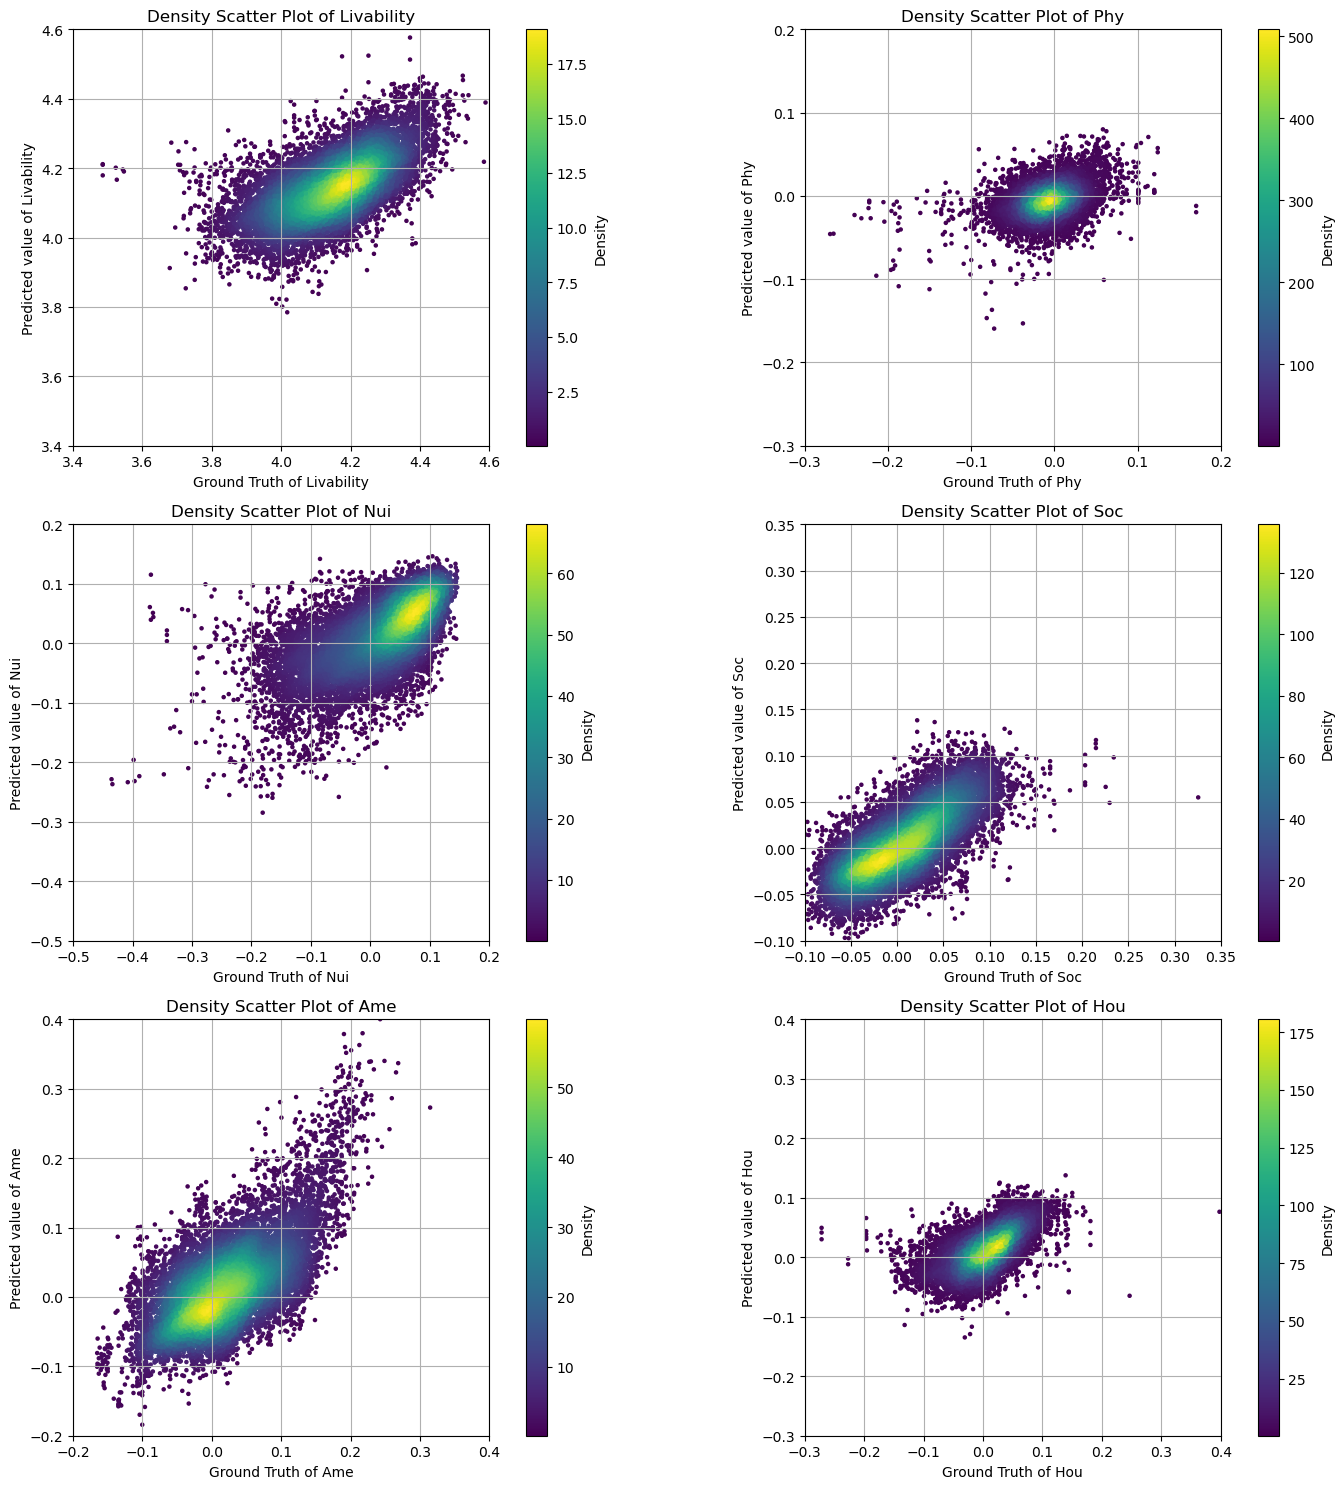

01/20/2026 03:41:31 - INFO - __main__ -   ***** Eval results  *****
01/20/2026 03:41:31 - INFO - __main__ -     loss = 0.0034118754020060547
01/20/2026 03:41:31 - INFO - __main__ -     r_Pearson_6 = 0.9992842890549642
01/20/2026 03:41:31 - INFO - __main__ -     r_Pearson_fys = 0.3522960687964338
01/20/2026 03:41:31 - INFO - __main__ -     r_Pearson_lbm = 0.6123643425191286
01/20/2026 03:41:31 - INFO - __main__ -     r_Pearson_onv = 0.6263234761005222
01/20/2026 03:41:31 - INFO - __main__ -     r_Pearson_soc = 0.7204720953464078
01/20/2026 03:41:31 - INFO - __main__ -     r_Pearson_vrz = 0.6598004414248252
01/20/2026 03:41:31 - INFO - __main__ -     r_Pearson_won = 0.5795990462399896
01/20/2026 03:41:31 - INFO - __main__ -     r_squared_6 = tensor(0.9986)
01/20/2026 03:41:31 - INFO - __main__ -     r_squared_fys = tensor(0.0446)
01/20/2026 03:41:31 - INFO - __main__ -     r_squared_lbm = tensor(0.3694)
01/20/2026 03:41:31 - INFO - __main__ -     r_squared_onv = tensor(0.3763)
01/20/2026

Evaluation complete,Number of results: 22
global_step 8000
Loading model: /u/wz53/Livability_evaluation_baseline/livability_4M_6aspects/checkpoint-8000
Loading model file: /u/wz53/Livability_evaluation_baseline/livability_4M_6aspects/checkpoint-8000/pytorch_model.bin
✅ Model loaded
Starting evaluation...
Loading dataset 'Vinjou/Multimodal_urban_livability_evaluation_dataset' from Hugging Face... (evaluate=True, test=True)


01/20/2026 03:41:33 - INFO - __main__ -   ***** Running evaluation checkpoint-8000 *****
01/20/2026 03:41:33 - INFO - __main__ -     Num examples = 13440
01/20/2026 03:41:33 - INFO - __main__ -     Batch size = 16
Evaluating: 100%|███████████████████████████████████████████████| 840/840 [02:45<00:00,  5.08it/s]


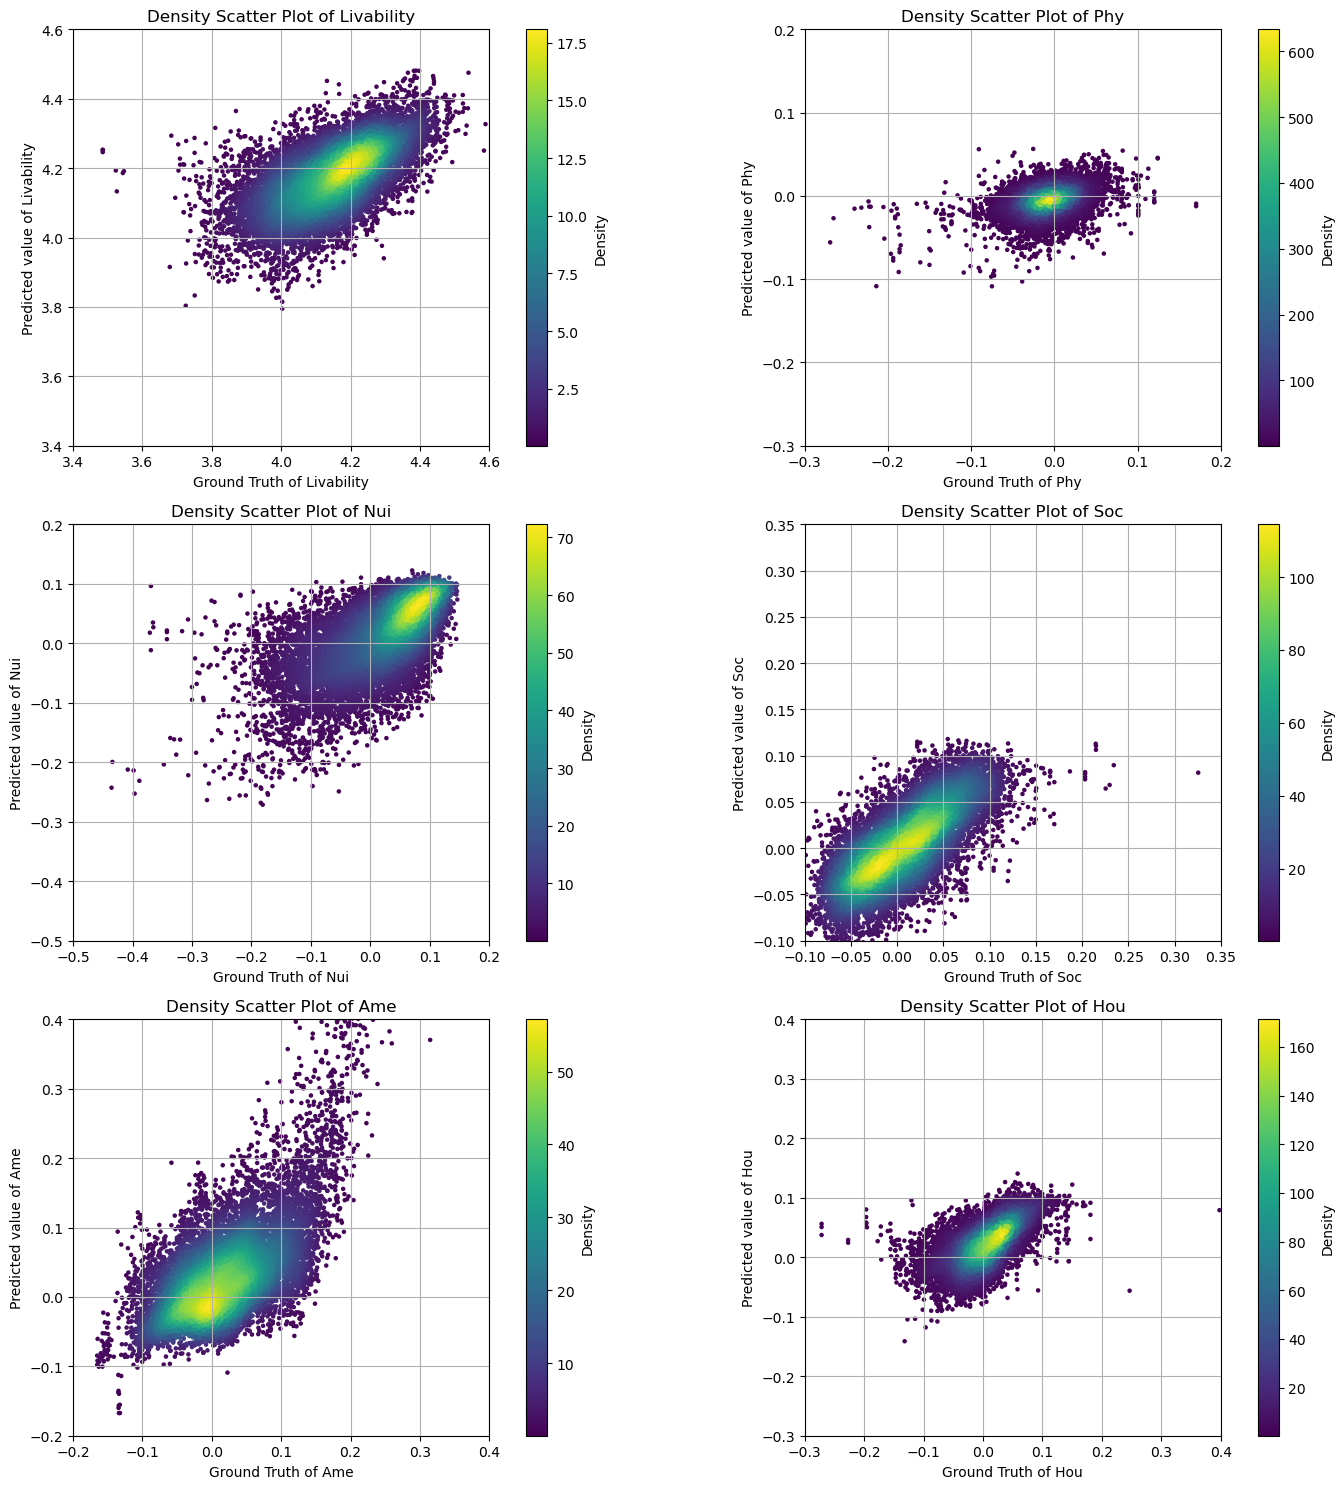

01/20/2026 03:44:34 - INFO - __main__ -   ***** Eval results checkpoint-8000 *****
01/20/2026 03:44:34 - INFO - __main__ -     loss = 0.0037459559031828705
01/20/2026 03:44:34 - INFO - __main__ -     r_Pearson_6 = 0.9992461764774259
01/20/2026 03:44:34 - INFO - __main__ -     r_Pearson_fys = 0.3387023271628132
01/20/2026 03:44:34 - INFO - __main__ -     r_Pearson_lbm = 0.6074930627681495
01/20/2026 03:44:34 - INFO - __main__ -     r_Pearson_onv = 0.6295645275540033
01/20/2026 03:44:34 - INFO - __main__ -     r_Pearson_soc = 0.7188398738624648
01/20/2026 03:44:34 - INFO - __main__ -     r_Pearson_vrz = 0.6437358225367801
01/20/2026 03:44:34 - INFO - __main__ -     r_Pearson_won = 0.6084651532164961
01/20/2026 03:44:34 - INFO - __main__ -     r_squared_6 = tensor(0.9984)
01/20/2026 03:44:34 - INFO - __main__ -     r_squared_fys = tensor(0.0741)
01/20/2026 03:44:34 - INFO - __main__ -     r_squared_lbm = tensor(0.3139)
01/20/2026 03:44:34 - INFO - __main__ -     r_squared_onv = tensor(0.3

Evaluation complete,Number of results: 22


dict_keys(['loss_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects', 'rmse_6_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects', 'r_squared_6_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects', 'r_Pearson_6_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects', 'rmse_lbm_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects', 'r_squared_lbm_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects', 'r_Pearson_lbm_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects', 'rmse_tgts_fys_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects', 'r_squared_fys_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects', 'r_Pearson_fys_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects', 'rmse_tgts_onv_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects', 'r_squared_onv_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects', 'r_Pearson_onv_/u/wz53/Livability_evaluation_baseline/livability_4

In [20]:
# Evaluation
results = {}
print("=== Start Model Evaluation ===")
print(f"do_eval = {args.do_eval}")
if args.do_eval:
    current_dir = os.getcwd()
    print(f"📁 Current working directory: {current_dir}")

    # Find Livability_evaluation_baseline directory (current, child, or parent)
    candidate_dirs = [
        current_dir,
        os.path.join(current_dir, "Livability_evaluation_baseline"),
        os.path.join(os.path.dirname(current_dir), "Livability_evaluation_baseline"),
    ]
    base_dir = None
    for candidate in candidate_dirs:
        if os.path.exists(candidate):
            base_dir = os.path.abspath(candidate)
            if os.path.basename(base_dir) == "Livability_evaluation_baseline":
                break
    if base_dir is None:
        base_dir = os.path.abspath(current_dir)

    print(f"📂 Base directory (Livability_evaluation_baseline): {base_dir}")

    # Resolve output_dir relative to base_dir
    if os.path.isabs(args.output_dir):
        output_dir_abs = args.output_dir
    else:
        output_dir_abs = os.path.abspath(os.path.join(base_dir, args.output_dir))

    print(f"📂 Resolved output_dir: {output_dir_abs}")
    print(f"📂 output_dir exists: {os.path.exists(output_dir_abs)}")

    # Update args.output_dir to use absolute path
    args.output_dir = output_dir_abs

    # Start with the root output_dir (may contain pytorch_model.bin)
    checkpoints = []
    
    # Check if root output_dir has pytorch_model.bin
    root_model_path = os.path.join(args.output_dir, 'pytorch_model.bin')
    if os.path.exists(root_model_path):
        checkpoints.append(args.output_dir)
        print(f"✅ Found root model: {args.output_dir}")
    
    if args.eval_all_checkpoints:
        # Search for folders containing "checkpoint" keyword
        checkpoint_dirs = []
        if os.path.exists(args.output_dir):
            for item in os.listdir(args.output_dir):
                item_path = os.path.join(args.output_dir, item)
                if os.path.isdir(item_path) and "checkpoint" in item:
                    # Check if pytorch_model.bin exists in the directory
                    model_file = os.path.join(item_path, "pytorch_model.bin")
                    if os.path.exists(model_file):
                        checkpoint_dirs.append(item_path)
        
        if checkpoint_dirs:
            checkpoints.extend(sorted(checkpoint_dirs))
            print(f"✅ Found checkpoint folders: {checkpoint_dirs}")
        else:
            print(f"⚠️  No checkpoint folders found in: {args.output_dir}")
    
    # If no checkpoints found at all, still try to use output_dir
    if not checkpoints:
        checkpoints = [args.output_dir]
        print(f"⚠️  No models found, will try: {args.output_dir}")

    logger.info("Evaluate the following checkpoints: %s", checkpoints)
    print(f"Found {len(checkpoints)} checkpoints: {checkpoints}")

    for checkpoint in checkpoints:
        global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
        print ("global_step",global_step)        
        prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""
        print(f"Loading model: {checkpoint}")
        model = MMBTForClassification(transformer_config, multimodal_config)
        model_path = os.path.join(checkpoint, 'pytorch_model.bin')
        print(f"Loading model file: {model_path}")
        
        # Load state_dict and handle compatibility issues
        state_dict = torch.load(model_path)
        
        # Remove keys that may cause compatibility issues
        keys_to_remove = []
        problematic_patterns = ['position_ids', 'token_type_ids']
        
        for key in state_dict.keys():
            for pattern in problematic_patterns:
                if pattern in key and 'embeddings' in key:
                    keys_to_remove.append(key)
                    break
        
        if keys_to_remove:
            print(f"🔧 Removed {len(keys_to_remove)} incompatible keys:")
            for key in keys_to_remove:
                print(f"   - {key}")
                del state_dict[key]
        
        # Use strict=False to allow partial matching
        missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)
        
        if missing_keys:
            print(f"⚠️  Missing keys: {len(missing_keys)} ")
        if unexpected_keys:
            print(f"⚠️  Unexpected keys: {len(unexpected_keys)} ")
        
        print("✅ Model loaded")
        model.to(args.device)
        print("Starting evaluation...")
        result = evaluate(args, model, tokenizer, evaluate=True, test=True, prefix=prefix)
        print(f"Evaluation complete,Number of results: {len(result)}")
        result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
        results.update(result)

results.keys()

In [21]:
print("=== Evaluation results ===")
print(f"Number of results: {len(results)}")
if results:
    print("Result details:")
    for key, value in results.items():
        print(f"  {key}: {value}")
else:
    print("NoFoundEvaluation results！")

results

=== Evaluation results ===
Number of results: 44
Result details:
  loss_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects: 0.0034118754020060547
  rmse_6_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects: 0.058411259204149246
  r_squared_6_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects: 0.9985690712928772
  r_Pearson_6_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects: 0.9992842890549642
  rmse_lbm_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects: 0.10351485013961792
  r_squared_lbm_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects: 0.36944520473480225
  r_Pearson_lbm_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects: 0.6123643425191286
  rmse_tgts_fys_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects: 0.02708091028034687
  r_squared_fys_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects: 0.04461681842803955
  r_Pearson_fys_/u/wz53/Livability_evaluation_baseline/livability_4M_

{'loss_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects': 0.0034118754020060547,
 'rmse_6_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects': tensor(0.0584),
 'r_squared_6_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects': tensor(0.9986),
 'r_Pearson_6_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects': 0.9992842890549642,
 'rmse_lbm_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects': tensor(0.1035),
 'r_squared_lbm_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects': tensor(0.3694),
 'r_Pearson_lbm_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects': 0.6123643425191286,
 'rmse_tgts_fys_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects': tensor(0.0271),
 'r_squared_fys_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects': tensor(0.0446),
 'r_Pearson_fys_/u/wz53/Livability_evaluation_baseline/livability_4M_6aspects': 0.3522960687964338,
 'rmse_tgts_onv_/u/wz53/Livability_evaluation_

## Saving Test Eval Results

The code automatically saved evaluation result from each checkpoint in its respective folder. This next cell simply saves all of them in one place.

In [22]:
with open(os.path.join(args.output_dir, "final_eval_results.txt"), mode='a', encoding='utf-8') as out_f:
    print(results, file=out_f)